# Predviđanje veza u mreži korz vrijeme


*Temporal link prediction* iliti *TLP*.


## Priprema okruženja


In [1]:
# Standardna Python biblioteka.
import copy
import functools
import math
import numbers
import warnings

# SciPy paketi.
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Paket Hyperopt.
import hyperopt as ho


In [2]:
%matplotlib inline


In [3]:
from tlp import *


Using numpy backend.


## Generiranje mreže s vremenskom dimenzijom


Mrežu definiramo kao matricu (na indeksu $ \left( i , j \right) $ je težina veze $ i $-tog čvora u prvoj domeni u vezi s $ j $-tim čvorom u drugoj domeni, pri čemu težina $ 0 $ označava da veze nema, a, ako je mreža bez težina, veze su označene težinom $ 1 $; ako su domene mreže iste i mreža je neusmjerena, matrica je simetrična), a stanja mreže kao tenzor kojemu su rezovi po zadnjoj dimenziji, gledani kao matrice, stanja mreže u određenom trenutku.

Zbog manjka izvora stvarnih podataka, mrežu ćemo generirati vlastoručno.


### Definicija parametara


In [4]:
M = 10
N = 10
T = 40


In [5]:
k = 6


### Generiranje slučajne mreže bez pretpostavke periodičnosti


Sljedeći dio k&ocirc;da (trenutno zakomentiran) služi zato da izračunamo norme komponenti tenzora čiji su elementi cijeli brojevi u intervalu $ \left[ 0 \mathinner{\ldotp \ldotp} 20 \right] $ tako da je očekivana popunjenost u svakom rezu po trećoj dimenziji $ 50 \, \% $. Inicijalno su svi brojevi iz intervala $ \left[ 1 \mathinner{\ldotp \ldotp} 20 \right] $ birani uniformno vjerojatno, zatim su oni među njima koji premašuju $ 10 $ s $ 50 $-postotnom vjerojatnosti umanjeni za $ 10 $, a, konačno, svaki element je u svakom rezu s $ 50 $-postotnom vjerojatnosti postavljen na $ 0 $.


In [6]:
# Z = np.random.randint(1, 21, size = (M, N, T), dtype = int).copy(order = 'F')
# for i in iter(range(T)):
#     for r in iter(range(M)):
#         for s in iter(range(N)):
#             if Z[r, s, i] > 10:
#                 if np.random.binomial(1, 0.5):
#                     Z[r, s, i] -= 10
#         try:
#             del s
#         except (NameError, UnboundLocalError):
#             pass
#     try:
#         del r
#     except (NameError, UnboundLocalError):
#         pass
#     Z[
#         np.random.binomial(
#             1,
#             0.5,
#             size = (M, N)
#         ).astype(bool).copy(order = 'F'),
#         i
#     ] = 0
# try:
#     del i
# except (NameError, UnboundLocalError):
#     pass


Od generiranog tenzora u sljedećoj čeliji računamo norme komponenti. Norme zatim spremamo u datoteku *lambda.npy*.


In [7]:
# from tensorly.decomposition import parafac as parafac

# cpd = list(parafac(Z.astype(float), k))

# l = np.ones(k, dtype = float, order = 'F')
# for i in iter(range(k)):
#     for j in iter(range(len(cpd))):
#         if (cpd[j][:, i] != 0).any():
#             l[i] *= np.linalg.norm(cpd[j][:, i])
#         else:
#             l[i] = 0
#     try:
#         del j
#     except (NameError, UnboundLocalError):
#         pass
# try:
#     del i
# except (UnboundLocalError):
#     pass
# l = np.flip(np.sort(l)).copy(order = 'F')

# del cpd

# np.save('lambda.npy', l)

# del parafac


### Generiranje slučajne mreže s pretpostavkom periodičnosti


Sljedeći dio koda služi za generiranje mreže u kojoj po trećoj dimenziji možemo donekle očekivati periodičnost. Mrežu generiramo tako da generiramo njen rastav na komponente, a zatim te komponente množimo u tenzor (mrežu). Na kraju osiguravamo da su vrijednosti u mreži cjelobrojne i iz intervala $ \left[ 0 \mathinner{\ldotp \ldotp} 20 \right] $.


Učitajmo norme komponenti tenzora kojeg ćemo generirati.


In [8]:
l = np.load('lambda.npy')
l = l[:k].copy(order = 'F')


Učitajmo *očekivanja* i *standardne devijacije* za generiranje Fourirerovih redova kojima ćemo generirati periodične nizove.


In [9]:
mu = (np.load('mu_real.npy'), np.load('mu_imag.npy'))
sigma = (np.load('sigma_real.npy'), np.load('sigma_imag.npy'))


Sljedeći parametri služe za generiranje treće komponente iz koeficijenata Fourirerovog reda. Parametar `m` prosljeđuje se funkciji `numpy.fft.irfft` kao duljina niza koji se generira, parametar `n` prosljeđuje se funkciji `rand_fft` kao broj koeficijenata koji se generiraju, a parametar `t` definira *šum*: svakom se generiranom nizu dodatno zbrajaju vrijednosti slučajno birane po normalnoj distribuciji s očekivanjem $ 0 $ i standardnom devijacijom `t * D` gdje je `D` razlika između najveće i najmanje vrijednosti niza.


In [10]:
m = 1025
n = 32
t = 0.0675


Generirajmo prve i druge komponente. Generiramo ih slučajnim biranjem vrijednosti normalnom distribucijom s očekivanjem $ 0 $ i varijancom $ 1 $, ali, negativne vrijednosti zatim postavljamo na $ 0 $, a komponente, naravno, normiramo.


In [11]:
a = np.random.randn(k, M).astype(float)
b = np.random.randn(k, N).astype(float)

for i in iter(range(k)):
    a[i, a[i] <= 0] = 0
    b[i, b[i] <= 0] = 0
    if (a[i] != 0).any():
        a[i, :] /= np.linalg.norm(a[i])
    else:
        a[i, :] = 0
    if (b[i] != 0).any():
        b[i, :] /= np.linalg.norm(b[i])
    else:
        b[i, :] = 0
try:
    del i
except (NameError, UnboundLocalError):
    pass

a = a.T.copy(order = 'F')
b = b.T.copy(order = 'F')


Generirajmo sada postepeno treće komponente. Prvo, funkcijama `rand_fft` i `numpy.fft.irfft` generirajmo `k` komponenti duljine `m`.


In [12]:
c = np.array(
    [np.fft.irfft(rand_fft(n, mu, sigma), n = m) for i in iter(range(k))],
    dtype = float,
    order = 'F'
)

try:
    del i
except (NameError, UnboundLocalError):
    pass


Dodajmo tim komponentama sada i šum.


In [13]:
for i in iter(range(k)):
    D = float(c[i].max() - c[i].min())
    c[i] += t * D * np.random.randn(m)
    del D
try:
    del i
except (NameError, UnboundLocalError):
    pass


Iz nizova duljine `m` ekstrahirajmo sada `T` ravnomjerno raspoređenih vrijednosti.


In [14]:
I = np.linspace(
    0.0,
    float(m),
    num = T + 1,
    dtype = float
).round().astype(int).copy(order = 'F')
I = I[:-1].copy(order = 'F')

c = c[:, I].copy(order = 'F')

del I


Normirajmo sada treće komponente, ali prije toga, po volji, tretirajmo negativne vrijednosti. Trenutno su predložene opcije (zakomentirane linije) uzimanje apsolutnih vrijednosti elemenata komponenti, translacija komponenti tako da im je najmanja postignuta vrijednost $ 0 $ i postavljanje svih negativnih vrijednosti na $ 0 $.


In [15]:
for i in iter(range(k)):
#   c[i, :] = np.abs(c[i])
#   c[i, :] -= c[i].min()
#   c[i, c[i] <= 0] = 0
    if (c[i] != 0).any():
        c[i] /= np.linalg.norm(c[i])
    else:
        c[i, :] = 0
try:
    del i
except (NameError, UnboundLocalError):
    pass


Konačno, pretvorimo treće komponente u stupce umjesto redaka.


In [16]:
c = c.T.copy(order = 'F')


Demonstracije radi, prikažimo treće komponente grafički. Periodičnost bi se trebala nazirati, ali bi trebala biti iskvarena ovisno o šumu zadanom parametrom `t`.


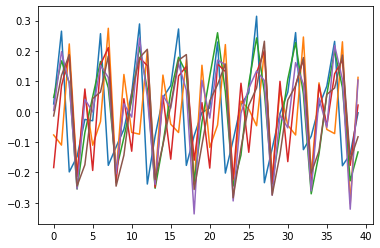

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

for i in iter(range(k)):
    ax.plot(c[:, i])
try:
    del i
except (NameError, UnboundLocalError):
    pass
plt.show()


In [18]:
del fig
del ax


Nakon što smo generirali normirane komponente, izmnožimo ih u tenzor. Zatim *rastegnimo* odnosno *kontrahirajmo* vrijednosti u dobivenom vrijednosti tako da $ 80 $-i centil postavimo na $ 20 $ ako je on strogo pozitivan (u protivnom tenzor samo izmnožimo s $ 20 $), zaokružimo vrijednosti u tenzoru na cijele brojeve, vrijednosti veće od $ 20 $ umanjujemo za $ 20 $ dok ne premašuju $ 20 $ i na kraju sve negativne vrijednosti postavimo na $ 0 $.


In [19]:
Z = np.zeros((M, N, T), dtype = float).copy(order = 'F')
for i in iter(range(k)):
    Z += (
        l[i] *
        a[:, i].reshape((M, 1, 1)) *
        b[:, i].reshape((1, N, 1)) *
        c[:, i].reshape((1, 1, T))
    )
H = np.percentile(Z, 80)
if H <= 0:
    Z = 20 * Z
else:
    Z = 20 * Z / H
Z = Z.round().astype(int).copy(order = 'F')
while (Z > 20).any(): # vjerojatno se može pametnije uz upotrebu operatora %
    Z[Z > 20] -= 20   # odnosno %=
Z[Z <= 0] = 0


Provjerimo *popunjenost* generiranog tenzora (udio njegovih elemenata različitih od $ 0 $).

***Napomena.*** Ukupna popunjenost ne znači da je tolika popunjenost u svakom rezu po zadnjoj dimenziji, kao što smo radili kod generiranja mreže bez pretpostavke periodičnosti.


In [20]:
float((Z > 0).sum(dtype = float) / Z.size)


0.37825

## Predviđanje vrijednosti mreže


Pretpostavimo da pažljivim odabirom parametara možemo predvidjeti stanje mreže. Te parametre možemo optimizirati paketom *Hyperopt*. U tu svrhu definirajmo funkciju `optim` kojom ćemo predikciju optimizirati i to tako da funkcija, osim parametara `theta` za metodu `ExponentialSmooth.predict`, može optimizirati i duljinu perioda (za metodu `ExponentialSmooth.fit`), parametre `k` i `T0` za funkciju `cp_score`, pa čak i broj rezova koji se predviđaju. Naravno da parametre `T0` i broj rezova koje predviđamo možda nema smisla optimizirati (oni mogu biti zadani unaprijed), stoga funkcija dopušta i njihovu direktnu definiciju. U stvari, svi se parametri osim parametra `theta` za metodu `ExponentialSmooth.predict` mogu zadati direktno (ako nisu `None`, onda se ne smiju pojavljivati kao parametri za optimizirati; jedino duljina perioda ne smije biti `None` i ne pojavljivati se kao parametar za optimizirati).

Funkcija greške koju minimiziramo je srednja kvadratna greška (predviđenih vrijednosti u odnosu na stvarne).


In [21]:
def optim (space, Z, k = None, T0 = None, p = None, n = None):
    """
    space: rječnik hiperparametara,
    Z: kompletni tenzor (s rezovima koje treba predvidjeti),
    k: broj komponenti u CP dekompoziciji,
    T0: broj rezova koji se uzimaju u obzir kod predikcije,
    p: duljina perioda,
    n: broj zadnjih rezova u Z koje treba predvidjeti.

    """

    if 'k' not in space:
        assert k is None
    if 'T0' in space:
        assert T0 is None
    if 'n' in space:
        assert n is None
    assert (p is None) == ('p' in space)
    assert (n is None) == ('n' in space)

    if n is None:
        n = int(round(space['n']))
        if n <= 0 or n >= Z.shape[-1]:
            return {'status' : ho.STATUS_FAIL}
    else:
        assert n > 0 and n < Z.shape[-1]

    Z = np.moveaxis(Z, -1, 0).copy(order = 'F')

    X = np.moveaxis(Z[:-n], 0, -1).copy(order = 'F')
    Y = np.moveaxis(Z[-n:], 0, -1).copy(order = 'F')
    if n == 1:
        if Y.ndim == 1:
            Y = Y.dtype.type(Y[0])
        else:
            Y.shape = Y.shape[:-1]

    del Z

    Y_predicted = None

    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        with np.errstate(divide = 'raise', invalid = 'raise'):
            try:
                if n == 1:
                    Y_predicted = cp_score(
                        X,
                        k = int(round(space['k'])) if 'k' in space else k,
                        T0 = int(round(space['T0'])) if 'T0' in space else T0,
                        predict = (
                            lambda X : ExponentialSmooth().fit(
                                X.T,
                                int(round(space['p'])) if 'p' in space else p
                            ).predict(
                                1,
                                (
                                    space['theta0'],
                                    space['theta1'],
                                    space['theta2']
                                )
                            )
                        )
                    )
                else:
                    Y_predicted = cp_score(
                        X,
                        k = int(round(space['k'])) if 'k' in space else k,
                        T0 = int(round(space['T0'])) if 'T0' in space else T0,
                        predict = (
                            lambda X : ExponentialSmooth().fit(
                                X.T,
                                int(round(space['p'])) if 'p' in space else p
                            ).predict(
                                n,
                                (
                                    space['theta0'],
                                    space['theta1'],
                                    space['theta2']
                                )
                            ).T
                        )
                    )
            except (
                TypeError,
                ValueError,
                FloatingPointError,
                np.linalg.LinAlgError,
                RuntimeWarning
            ):
                return {'status' : ho.STATUS_FAIL}

    E = (Y - Y_predicted).copy(order = 'F')

    e = None
    if isinstance(E, np.ndarray):
        e = float(np.sqrt(np.square(E.ravel()).mean()))
    else:
        e = float(abs(E))

    return {'loss' : e, 'status' : ho.STATUS_OK}


Zadajmo parametre koje želimo optimizirati i razdiobe kojima će se njihove vrijednosti birati.


In [22]:
space = {
    'k' : ho.hp.quniform('k', 1.0, float(min(Z.shape)), 1.0),
    'T0' : ho.hp.quniform('T0', 1.0, float(Z.shape[-1]), 1.0),
    'p' : ho.hp.quniform('p', 1.0, float(Z.shape[-1]), 1.0),
    'n' : ho.hp.quniform('n', 1.0, float(Z.shape[-1]) - 1.0, 1.0),
    'theta0' : ho.hp.uniform('theta0', 0.0, 1.0),
    'theta1' : ho.hp.uniform('theta1', 0.0, 1.0),
    'theta2' : ho.hp.uniform('theta2', 0.0, 1.0)
}


Izvršimo optimizaciju hiperparametara i najbolje vrijednosti spremimo u objekt `space`.


In [23]:
trials = ho.Trials()
best = ho.fmin(
    fn = functools.partial(optim, Z = Z),
    space = space,
    algo = ho.tpe.suggest,
    max_evals = 2000,
    trials = trials,
    show_progressbar = True
)


100%|██████████| 2000/2000 [08:00<00:00,  2.56it/s, best loss: 2.406027861684413]


Ispišimo najbolji pronađeni izbor parametara.


In [24]:
best


{'T0': 30.0,
 'k': 7.0,
 'n': 2.0,
 'p': 5.0,
 'theta0': 0.5754539905222755,
 'theta1': 0.05023234530414475,
 'theta2': 0.9259468466189527}